In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import polars as ps

In [2]:
def update_z(z, Q, n, i, d_t=1):
    '''
    z: SoC
    Q: capacidade total (Ah)
    n: eficiência coulombiana/carga
    i: corrente (A)
    d_t: variação no tempo (h)
    '''
    z -= n*i*(d_t/Q)
    return max(z,0)

In [3]:
def r0(z):
    return 99+z*1

def r1(z):
    return 9+z*1

def c1(z):
    return 2.5+z*0.5

def OCV(z):
    return z*1+4

In [4]:
def update_v(z, i_r0, i_r1):
    return OCV(z) - i_r0*r0(z) - i_r1*r1(z)

In [5]:
def update_i_r1(z, i_r0, i_r1, d_t=1):
    e = np.exp(-d_t/(c1(z)*r1(z)))
    return i_r1*e+i_r0*(1-e)

In [6]:
z = 1

Q = 30
d_t = 1
n = 1

i_r1 = 0

V = []
I1 = []
Z = []
i0 = 0.01
I0 = ([0.0]*10+[i0]*200+[0.0]*190)*20

for i_r0 in I0:
    if z <= 0:
        I0 = I0[:len(V)]
        break
    v = update_v(z, i_r0, i_r1)
    z = update_z(z, Q, n, i_r0, d_t)
    i_r1 = update_i_r1(z, i_r0, i_r1, d_t)
    V.append(v)
    Z.append(z)
    I1.append(i_r1)
t = np.arange(len(V))
df = ps.DataFrame(data={'t':t,'V': V, 'I0': I0, 'Z': Z})


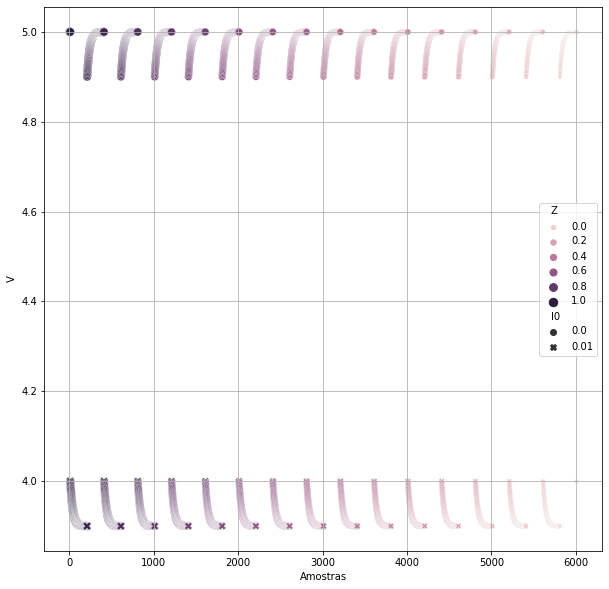

In [7]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df.to_pandas(), x='t', y='V', hue='Z', style='I0', size='Z')
plt.ylabel('V')
plt.xlabel('Amostras')
plt.grid()
plt.show()
plt.close()

In [8]:
df_ovc = df.filter((ps.col('I0').diff() > 0).shift(-1))[['t', 'V']]

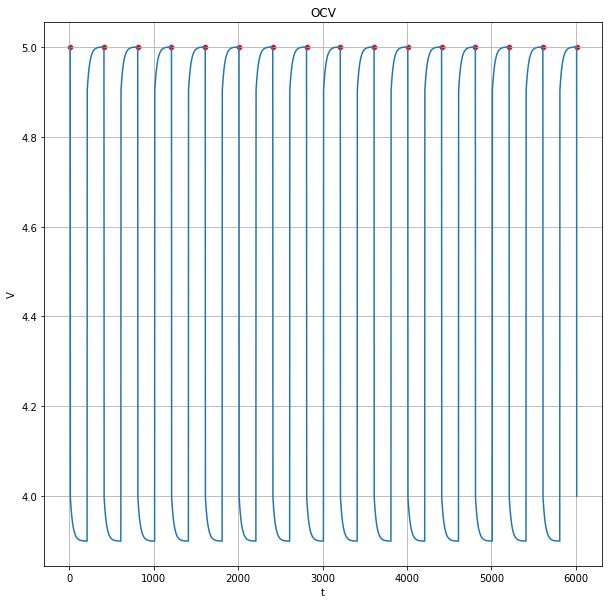

In [9]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df_ovc.to_pandas(), x='t', y='V', color='red')
sns.lineplot(data=df.to_pandas(), x='t', y='V')
plt.grid()
plt.title('OCV')
plt.show()
plt.close()

In [10]:
df['dV'] = df['V'].diff()
df['dI'] = df['I0'].diff()

In [11]:
r0_hat = df.filter(ps.col('dI')<0).select([ps.col('t')-1, (ps.col('dV')/i0).alias('r0')])

In [48]:
r0_hat['tipo'] = np.zeros(len(r0_hat))
df_c = r0_hat[['t','tipo']]
r0_hat = r0_hat.drop(['tipo'])

df_ovc['tipo'] = np.ones(len(df_ovc))
df_c.extend(df_ovc[['t','tipo']])
df_ovc = df_ovc.drop(['tipo'])

df_c.sort('t',in_place=True)

df_c = df_c.select(
    [
        ps.col('t').shift(1).alias('t_inicio')+1,
        ps.col('t').alias('t_fim'),
        ps.col('tipo'),
    ]
).filter(ps.col('tipo')==1.0
).filter(ps.col('t_inicio').is_not_null()
).filter(ps.col('t_fim').is_not_null()
).select([ps.col('t_inicio'), ps.col('t_fim')])

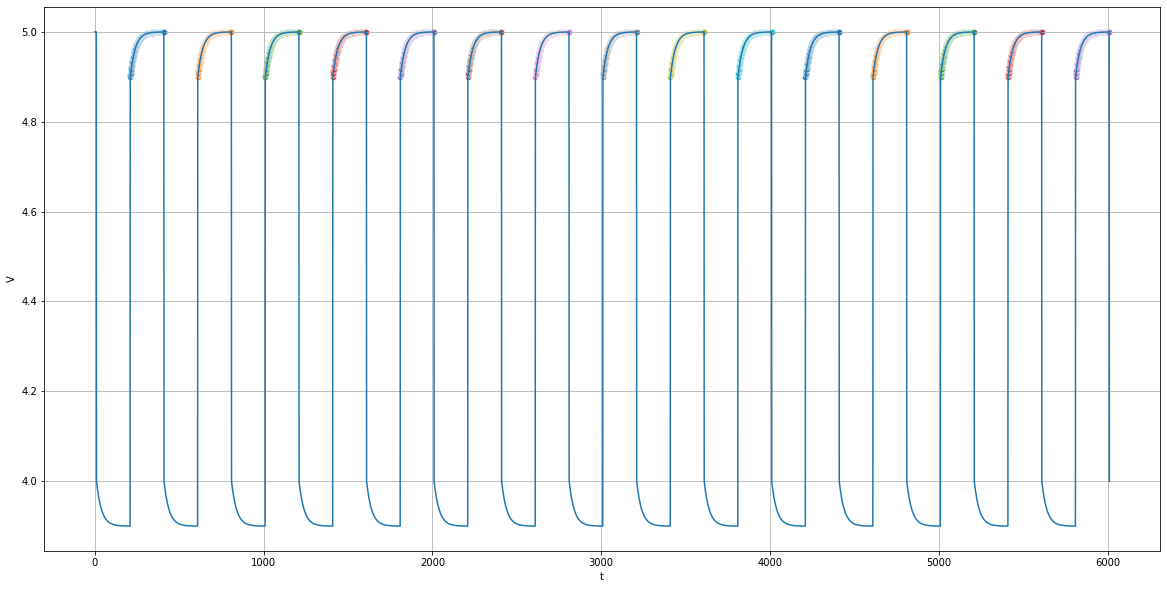

In [49]:
plt.figure(figsize=(20, 10))
sns.lineplot(data=df.to_pandas(), x='t', y='V')

tau = dict()

for t_inicio, t_fim in df_c.rows():
    v0 = df.filter(ps.col('t')==t_inicio)['V'].max()
    vinf = df.filter(ps.col('t')==t_fim)['V'].max()
    dv = vinf-v0

    for i in range(t_inicio, t_fim):
        vx = df.filter(ps.col('t')==i)['V'].max()

        if vx-v0 >= 0.632120*dv:
            tau[t_inicio-1] = i-t_inicio
            break

    a = df.filter(ps.col('t')>=t_inicio).filter(ps.col('t')<=t_fim)
    sns.scatterplot(data=a.to_pandas(), x='t', y='V')

plt.grid()
plt.show()
plt.close()   

In [50]:
# TODO: replace 100 and 101 with calculate values
r1_hat = dict()
for t_inicio, t_fim in df_c.rows():
    t = t_inicio-1
    dv = (df[t:t_fim+1]['V'].max() - df[t:t_fim+1]['V'].min())
    r1_hat[t] = dv/i0-r0_hat.filter(ps.col('t')==t)['r0'].max()
r1_hat = ps.DataFrame({'t':list(r1_hat.keys()), 'r1':list(r1_hat.values())})

In [51]:
c1_hat = dict()
for t_inicio, t_fim in df_c.rows():
    t = t_inicio-1
    r1_ = r1_hat.filter(ps.col('t')==t)['r1'].max()
    c1_hat[t] = tau[t]/(r1_)
c1_hat = ps.DataFrame({'t':list(c1_hat.keys()), 'c1':list(c1_hat.values())})

In [52]:
df_ovc

t,V
i64,f64
9,5.0
409,4.999869
809,4.999869
1209,4.999869
1609,4.999869
2009,4.999869
2409,4.999869
2809,4.999869
3209,4.999869


In [53]:
c1_hat

t,c1
i64,f64
209,3.0077
609,3.007775
1009,3.007775
1409,3.007775
1809,3.007775
2209,3.007775
2609,3.007775
3009,3.007775
3409,3.007775


In [54]:
r1_hat

t,r1
i64,f64
209,9.974133
609,9.974149
1009,9.974149
1409,9.974149
1809,9.974149
2209,9.974149
2609,9.974149
3009,9.974149
3409,9.974149


In [55]:
r0_hat

t,r0
i64,f64
209,99.999569
609,99.999569
1009,99.999569
1409,99.999569
1809,99.999569
2209,99.999569
2609,99.999569
3009,99.999569
3409,99.999569


In [44]:
print(r0_hat['r0'].mean()-r0(0))
print(df_ovc['V'].mean()-OCV(0))
print(c1_hat['c1'].mean()-c1(0))
print(r1_hat['r1'].mean()-r1(0))

-0.0004308489562987461
-0.0001231966276602492
0.007775766461379341
-0.025852214608530488
